In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

In [3]:
# Load the Excel file
df = pd.read_excel('C:/Users/Galindo/Desktop/Energy_consumption.xls', header=14)

# Remove the 'Unnamed: 3' column
df.drop(columns=['Unnamed: 3'], inplace=True)
excel = df.copy()
excel_1 = df.copy()
# Check the column names
print(df.columns)

# Check for null values
print(df.isnull().sum())

print(df)


Index(['Date', 'Hour', 'Q-Enginyeria-Total [kWh]'], dtype='object')
Date                        0
Hour                        0
Q-Enginyeria-Total [kWh]    0
dtype: int64
                     Date                Hour  Q-Enginyeria-Total [kWh]
0     2018-01-01 00:00:00 2018-01-01 00:00:00                177.000000
1     2018-01-01 01:00:00 2018-01-01 01:00:00                177.440000
2     2018-01-01 02:00:00 2018-01-01 02:00:00                176.570000
3     2018-01-01 03:00:00 2018-01-01 03:00:00                174.980000
4     2018-01-01 04:00:00 2018-01-01 04:00:00                174.510000
...                   ...                 ...                       ...
53624 2024-02-13 08:00:00 2024-02-13 08:00:00                363.222567
53625 2024-02-13 09:00:00 2024-02-13 09:00:00                388.690476
53626 2024-02-13 10:00:00 2024-02-13 10:00:00                417.800000
53627 2024-02-13 11:00:00 2024-02-13 11:00:00                440.495455
53628 2024-02-13 12:00:00 2024-02-13 

VISUALIZATION BASED ON MEANS

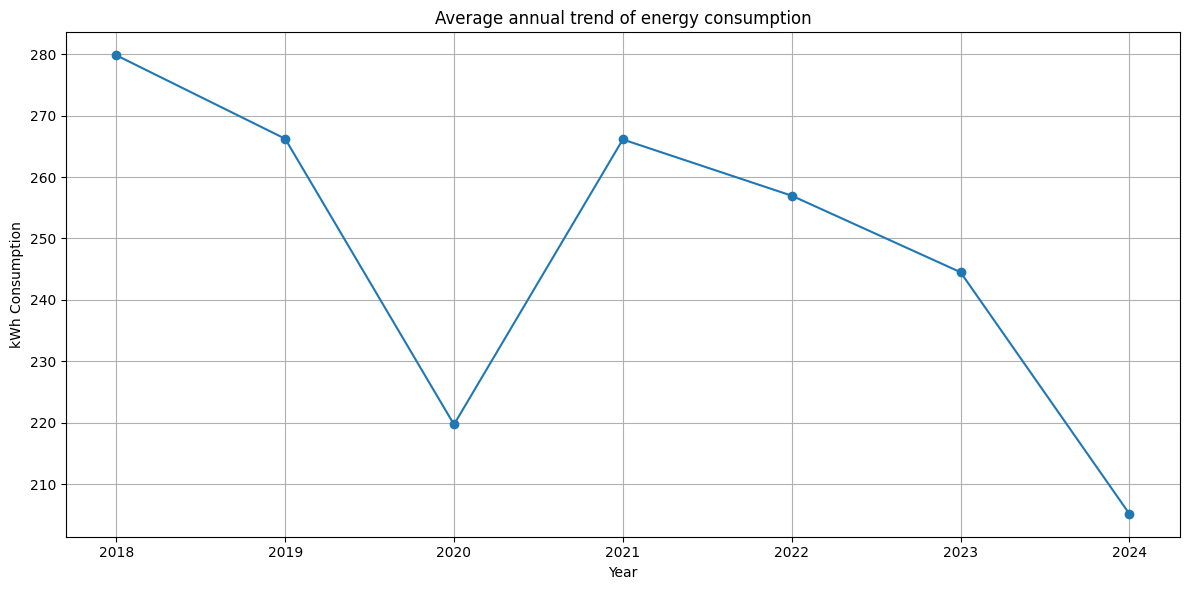

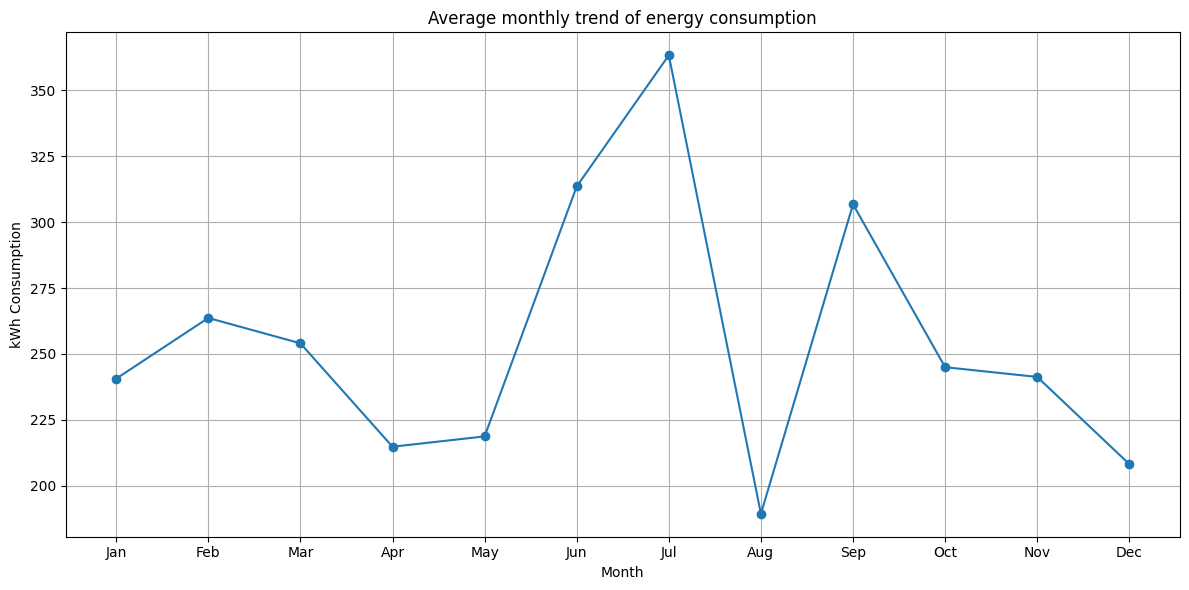

In [4]:
# Calculate the average kWh consumption per year and per month
yearly_consumption = df.groupby(df['Date'].dt.year)['Q-Enginyeria-Total [kWh]'].mean()
monthly_consumption = df.groupby(df['Date'].dt.month)['Q-Enginyeria-Total [kWh]'].mean()

# Visualization of average annual trend
plt.figure(figsize=(12, 6))
yearly_consumption.plot(marker='o', linestyle='-')
plt.title('Average annual trend of energy consumption')
plt.xlabel('Year')
plt.ylabel('kWh Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization of average monthly trend
plt.figure(figsize=(12, 6))
monthly_consumption.plot(marker='o', linestyle='-')
plt.title('Average monthly trend of energy consumption')
plt.xlabel('Month')
plt.ylabel('kWh Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()


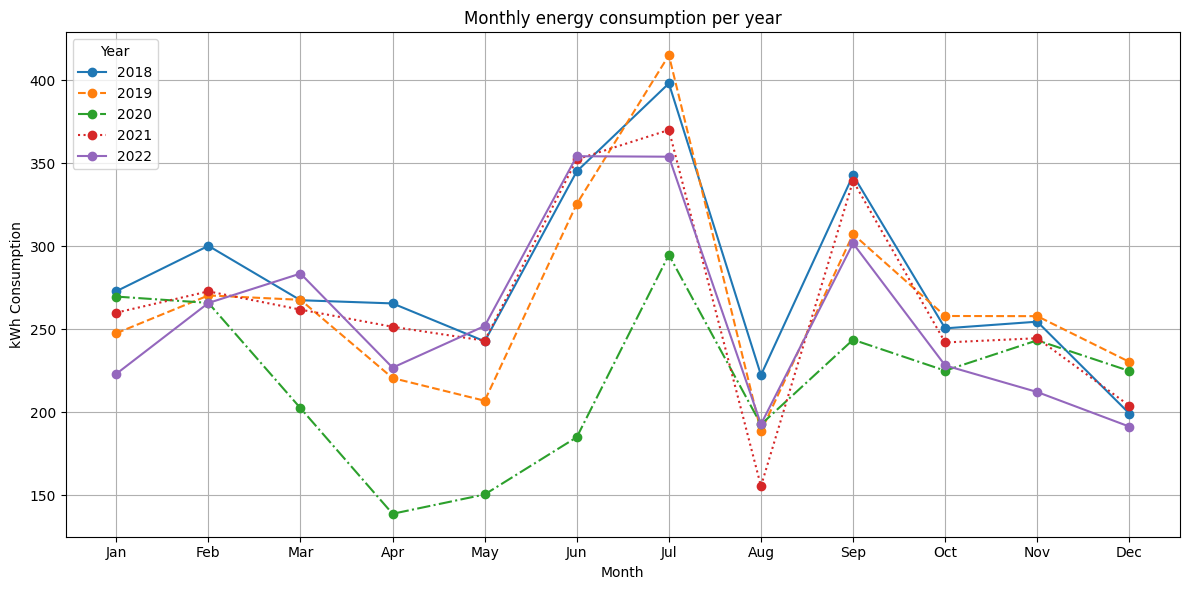

In [5]:
# Colors for each line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Line style and markers
line_styles = ['-', '--', '-.', ':', '-']

# Calculate the average kWh consumption per month and per year
yearly_monthly_consumption = df.groupby([df['Date'].dt.year, df['Date'].dt.month])['Q-Enginyeria-Total [kWh]'].mean().unstack()

# Transpose the data to have years as columns and months as rows
yearly_monthly_consumption = yearly_monthly_consumption.T

# Visualization of the comparison of monthly energy consumption between different years
plt.figure(figsize=(12, 6))
for i, (year, color, line_style) in enumerate(zip(yearly_monthly_consumption.columns, colors, line_styles)):
    plt.plot(yearly_monthly_consumption.index, yearly_monthly_consumption[year], marker='o', linestyle=line_style, color=color, label=year)

plt.title('Monthly energy consumption per year')
plt.xlabel('Month')
plt.ylabel('kWh Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()


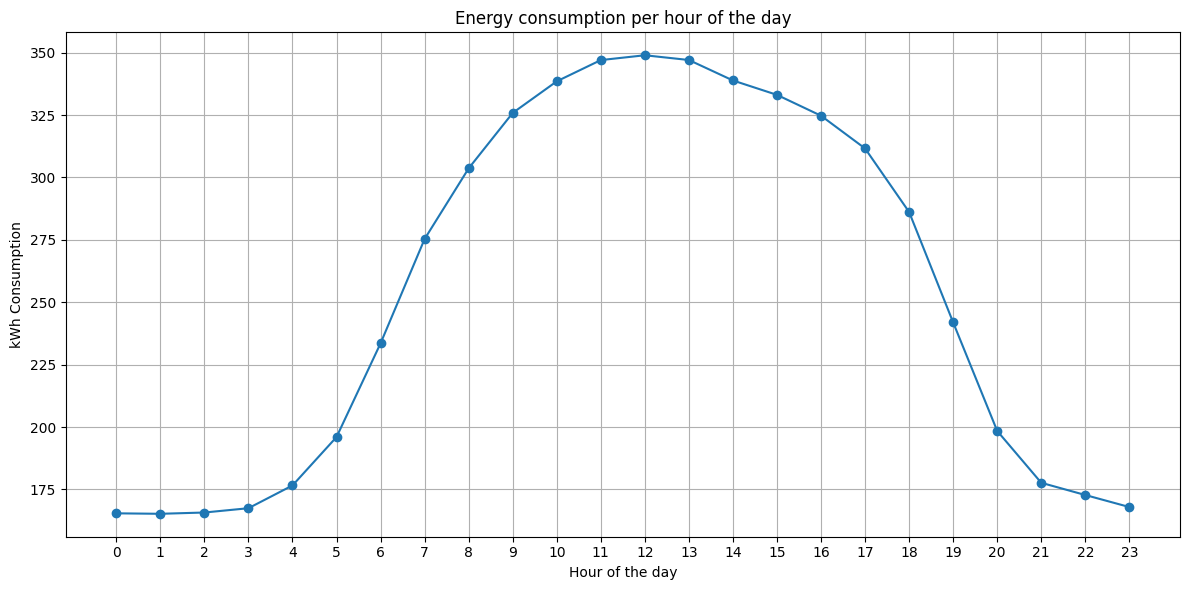

In [6]:
# Calculate the average kWh consumption per hour of the day
hourly_consumption = df.groupby(df['Date'].dt.hour)['Q-Enginyeria-Total [kWh]'].mean()

# Visualization of energy consumption per hour of the day
plt.figure(figsize=(12, 6))
hourly_consumption.plot(marker='o', linestyle='-')
plt.title('Energy consumption per hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('kWh Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


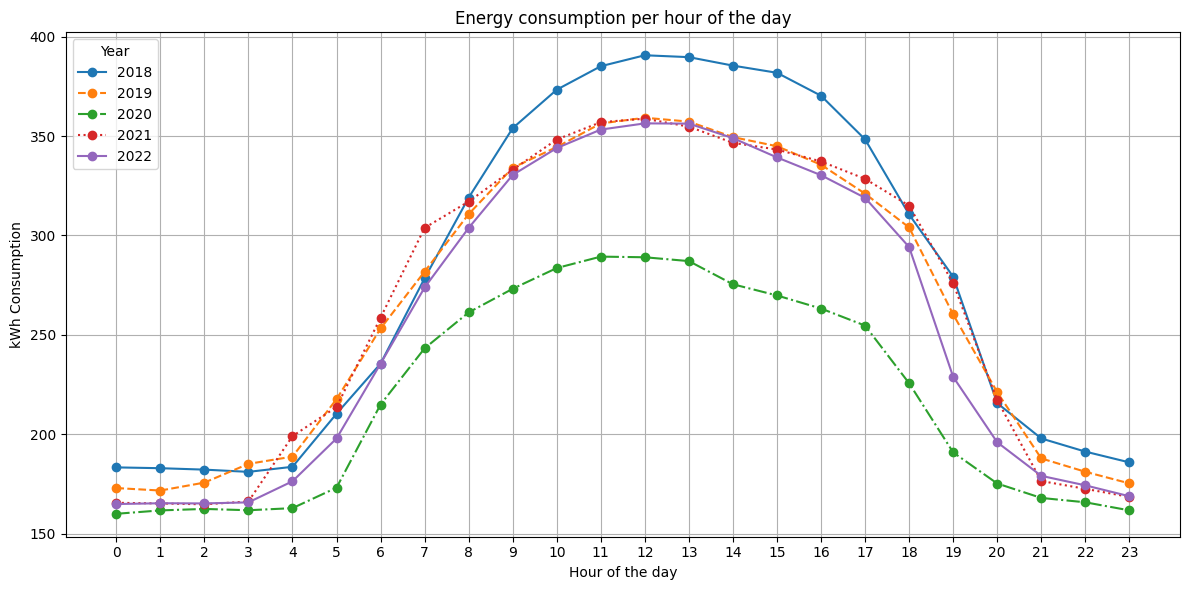

In [7]:
# Calculate the average kWh consumption per hour of the day
hourly_consumption = df.groupby([df['Date'].dt.year, df['Date'].dt.hour])['Q-Enginyeria-Total [kWh]'].mean().unstack()

# Transpose the data to have years as columns and hours as rows
hourly_consumption = hourly_consumption.T

# Colors for each line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Line style and markers
line_styles = ['-', '--', '-.', ':', '-']

# Visualization of energy consumption per hour of the day
plt.figure(figsize=(12, 6))
for i, (year, color, line_style) in enumerate(zip(hourly_consumption.columns, colors, line_styles)):
    plt.plot(hourly_consumption.index, hourly_consumption[year], marker='o', linestyle=line_style, color=color, label=year)

plt.title('Energy consumption per hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('kWh Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()


PREDICTIONS WITH DAILY AVERAGE

In [9]:
# Group the data by date and calculate the average energy consumption for each day
df_daily_avg = excel.groupby(excel['Date'].dt.date)['Q-Enginyeria-Total [kWh]'].mean().reset_index()
df_daily_avg.tail()


,Date,Q-Enginyeria-Total [kWh]
2230,2024-02-09,236.155235
2231,2024-02-10,122.058532
2232,2024-02-11,118.351190
2233,2024-02-12,261.608849
2234,2024-02-13,250.487692


In [16]:
# Convert 'Date' column to datetime
df_daily_avg['Date'] = pd.to_datetime(df_daily_avg['Date'])

# Group the data by month and sum the energy consumption
df_monthly_sum = df_daily_avg.groupby(df_daily_avg['Date'].dt.to_period('M'))['Q-Enginyeria-Total [kWh]'].sum().reset_index()

# Multiply each monthly sum by 0.2
df_monthly_sum['Q-Enginyeria-Total [kWh]'] = df_monthly_sum['Q-Enginyeria-Total [kWh]'] * 0.2 # €/kWh

# Rename the column
df_monthly_sum.rename(columns={'Q-Enginyeria-Total [kWh]': 'Price_per_month'}, inplace=True)

# Convert the 'Date' column to string format for plotting
df_monthly_sum['Date'] = df_monthly_sum['Date'].astype(str)

# Save the DataFrame to a CSV file
df_monthly_sum.to_csv('monthly_price.csv', index=False)

In [16]:
# Reshape the data for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(df_daily_avg[['Q-Enginyeria-Total [kWh]']])

# Optionally convert back to DataFrame for easier handling
daily_data_scaled = pd.DataFrame(daily_data_scaled, index=df_daily_avg.index, columns=['Q-Enginyeria-Total [kWh]'])

In [17]:
# Ensure the 'Date' column is in datetime format
df_daily_avg['Date'] = pd.to_datetime(df_daily_avg['Date'])

# Set the 'Date' column as the index
df_daily_avg.set_index('Date', inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(df_daily_avg[['Q-Enginyeria-Total [kWh]']])

# Optionally convert back to DataFrame for easier handling
daily_data_scaled = pd.DataFrame(daily_data_scaled, index=df_daily_avg.index, columns=['Q-Enginyeria-Total [kWh]'])

In [39]:
# Function to create dataset with look_back
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # use the last x days to predict the next day
X, Y = create_dataset(daily_data_scaled.values, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [40]:
# Define the model
model = Sequential()

# Define input shape
input_shape=(look_back, 1)

model.add(Input(shape=input_shape))
model.add(LSTM(units=17, return_sequences=True))
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Add dropout with 20% probability

model.add(LSTM(units=25, return_sequences=True))
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Add dropout with 20% probability

model.add(LSTM(units=15))  # This will be the last LSTM layer
model.add(Dense(units=1))  # Output layer, 1 unit for output

# Set the learning rate and compile the model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [41]:
# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.77)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Train the model
daily_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8, verbose=2)

Epoch 1/20
210/210 - 6s - 30ms/step - loss: 0.0377 - val_loss: 0.0275
Epoch 2/20
210/210 - 5s - 24ms/step - loss: 0.0333 - val_loss: 0.0278
Epoch 3/20
210/210 - 6s - 27ms/step - loss: 0.0288 - val_loss: 0.0144
Epoch 4/20
210/210 - 6s - 27ms/step - loss: 0.0183 - val_loss: 0.0113
Epoch 5/20
210/210 - 6s - 27ms/step - loss: 0.0125 - val_loss: 0.0067
Epoch 6/20
210/210 - 6s - 26ms/step - loss: 0.0112 - val_loss: 0.0062
Epoch 7/20
210/210 - 6s - 27ms/step - loss: 0.0098 - val_loss: 0.0068
Epoch 8/20
210/210 - 6s - 27ms/step - loss: 0.0087 - val_loss: 0.0110
Epoch 9/20
210/210 - 5s - 23ms/step - loss: 0.0105 - val_loss: 0.0079
Epoch 10/20
210/210 - 4s - 18ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 11/20
210/210 - 4s - 18ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 12/20
210/210 - 5s - 26ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 13/20
210/210 - 6s - 27ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 14/20
210/210 - 6s - 27ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 15/20
210

In [42]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(Y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test_inv, test_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train Score: 35.36 RMSE
Test Score: 35.36 RMSE


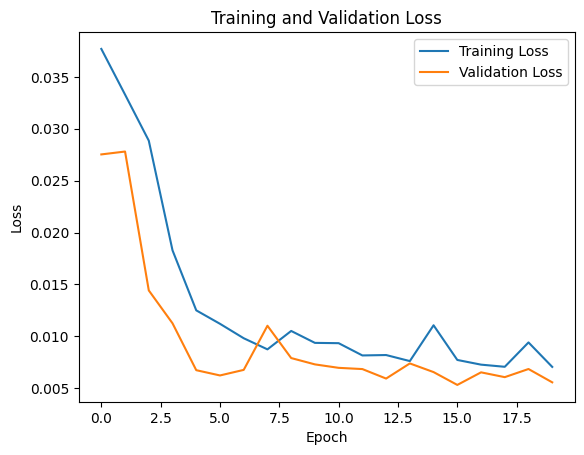

In [43]:
# Plot training and validation loss
plt.plot(daily_history.history['loss'], label='Training Loss')
plt.plot(daily_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


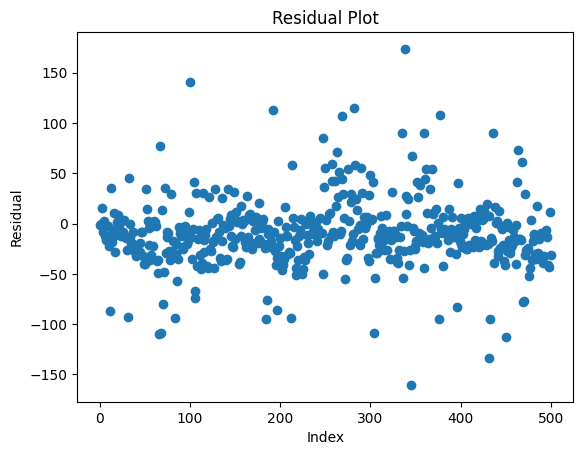

In [44]:
residuals = Y_test_inv.flatten() - test_predict.flatten()
# Plot residual plot, random scatter around zero suggest well-performance
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

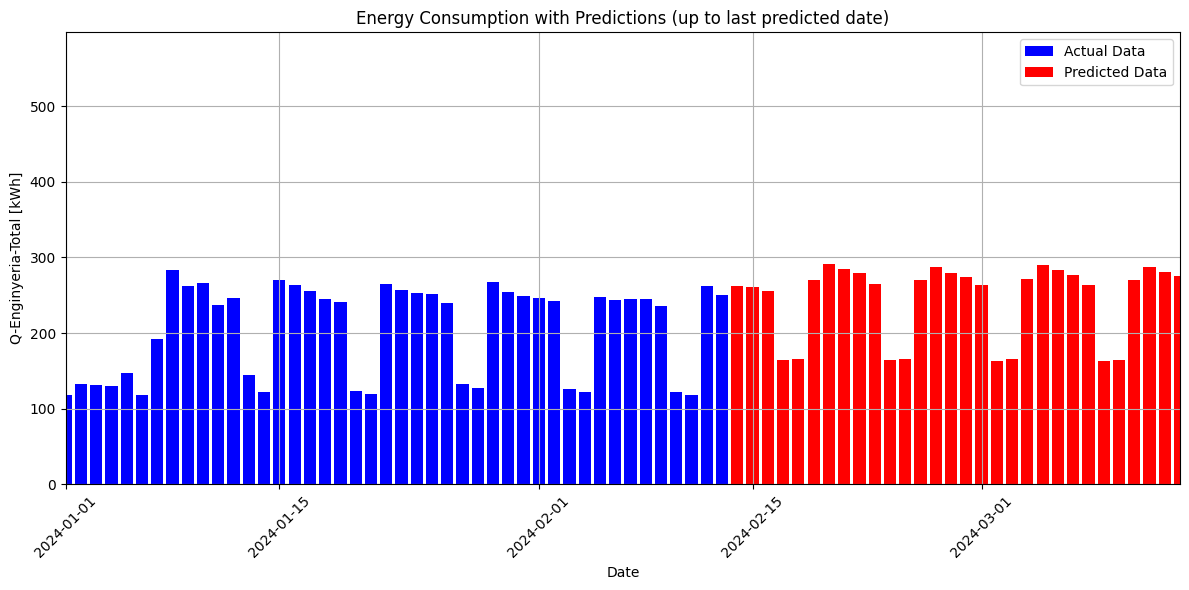

In [55]:
# Convert the index to datetime
df_daily_avg.index = pd.to_datetime(df_daily_avg.index)

# Generate timestamps for the next 30 days with daily frequency
future_dates = pd.date_range(start=df_daily_avg.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Reshape the data for the next 30 days
future_data = []

# Initialize the last known data as the initial input for the first prediction
last_known_data = daily_data_scaled[-look_back:].values.reshape((1, look_back, 1))

for i, future_date in enumerate(future_dates):
    # Make predictions for the next day
    predicted_value = model.predict(last_known_data)
    
    # Inverse transform the predicted value to the original scale
    predicted_value_original_scale = scaler.inverse_transform(predicted_value)
    
    # Append the predicted value to the future_data list
    future_data.append(predicted_value_original_scale[0][0])
    
    # Update last_known_data by removing the oldest value and appending the predicted value
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# Create a DataFrame for the predicted values and timestamps
predicted_df = pd.DataFrame({'Date': future_dates, 'Q-Enginyeria-Total [kWh]': future_data})

# Append the predicted data to the original DataFrame
data_with_predictions = pd.concat([df_daily_avg, predicted_df], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data as bar chart
plt.bar(df_daily_avg.index, df_daily_avg['Q-Enginyeria-Total [kWh]'], label='Actual Data', color='blue', width=0.8)

# Plot predicted data as bar chart
plt.bar(predicted_df['Date'], predicted_df['Q-Enginyeria-Total [kWh]'], label='Predicted Data', color='red', width=0.8)

plt.xlabel('Date')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.title('Energy Consumption with Predictions (up to last predicted date)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Set x-axis range to include only up to the last predicted date
plt.xlim(pd.Timestamp('2024-01-01'), predicted_df['Date'].iloc[-1])

plt.tight_layout()
plt.show()


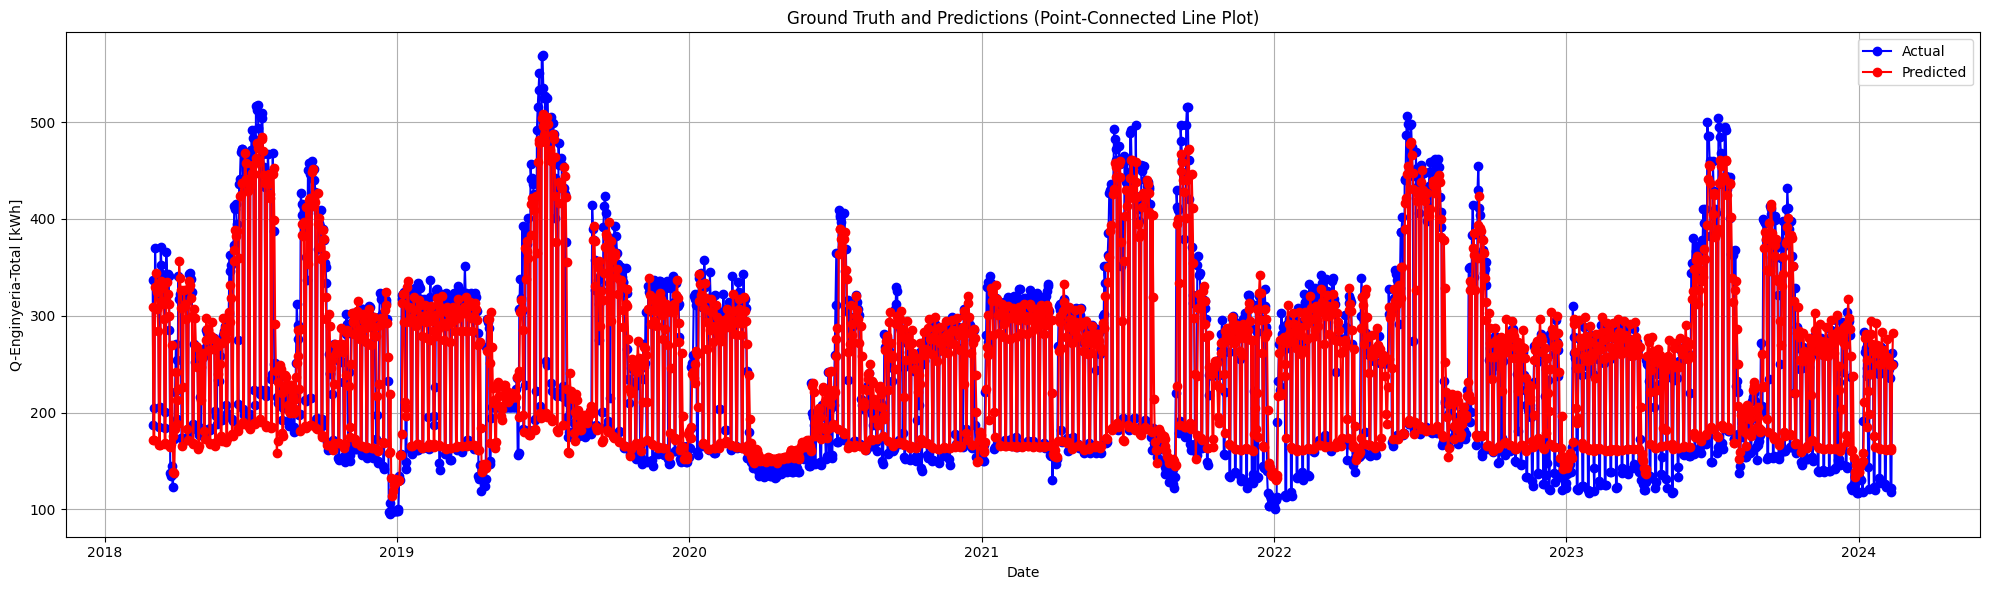

In [46]:
# Prepare date ranges for plotting
train_dates = df_daily_avg.index[look_back:train_size + look_back]
test_dates = df_daily_avg.index[train_size + look_back:]

# Combine the data for plotting
all_dates = np.concatenate((train_dates, test_dates))
all_actual = np.concatenate((Y_train_inv.flatten(), Y_test_inv.flatten()))
all_predict = np.concatenate((train_predict.flatten(), test_predict.flatten()))


x_length = len(all_dates)  # Take only x amount of data
all_dates = all_dates[:x_length]
all_actual = all_actual[:x_length]
all_predict = all_predict[:x_length]

# Plot the ground truth and the predictions as points connected by lines
plt.figure(figsize=(20, 6))

# Plot ground truth
plt.plot(all_dates, all_actual, label='Actual', color='blue', marker='o', linestyle='-')

# Plot predictions
plt.plot(all_dates, all_predict, label='Predicted', color='red', marker='o', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.title('Ground Truth and Predictions (Point-Connected Line Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
